# Mouse Analyzer
This entire document is aimed at performing analysis on Treadmill Mouse Raw Videos.
<br>End goal is to make a simple semi-automatic behavior classifier.

In [2]:
# Needed for interactive plot drawing
%matplotlib notebook

# Importing libs for numerical operations and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Importing libs for data preparation and analysis 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import KMeans

# Importing libs for statistics
from scipy.stats import pearsonr
from statsmodels.graphics.tsaplots import _prepare_data_corr_plot, _plot_corr
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf, pacf, ccf

# Data Preparation
The below cells prepare data and make it in a **readable** way.

In [3]:
# Loading our data video data;
# NOTE: This cell supposed to be extended so that multiple videos will be uploaded at the same same time
data = pd.read_csv('M-ephy4_body_0001 19-08-19 00-44-38DLC_resnet50_Mouse_treadmillDec18shuffle1_105000.csv',
                  header=1,
                  low_memory=False).drop(0)

data.drop(columns=['bodyparts'], inplace=True)
bodyparts2plot = data.columns[::3]

# Denotes which column corresponds to particular coordinate
for column in data.columns:
    if '.1' in column:
        data.rename(columns={column:column.replace('.1', '_yy')}, inplace=True)
    elif '.2' in column:
        data.rename(columns={column:column.replace('.2', '_p')}, inplace=True)
    else:
        data.rename(columns={column:column + '_xx'}, inplace=True)

# Add the column containing frame numbers
data['frame_number'] = np.arange(0, len(data))

# Make numeric format of DataFrame
data = data.apply(pd.to_numeric, errors='coerce')

# Display first 5 rows of data
data.head()

,front_paw_xx,front_paw_yy,front_paw_p,back_paw_tip_xx,back_paw_tip_yy,back_paw_tip_p,back_paw_ankle_xx,back_paw_ankle_yy,back_paw_ankle_p,flank_xx,...,ear_canal_xx,ear_canal_yy,ear_canal_p,eye_xx,eye_yy,eye_p,snout_xx,snout_yy,snout_p,frame_number
1,755.932983,282.012329,0.998967,347.596100,355.558319,0.999895,344.502777,318.979034,0.750598,288.519531,...,635.612854,164.862366,0.999938,758.572754,137.963791,0.999159,860.371582,172.629196,0.647869,0
2,745.628784,279.867950,0.995708,343.820923,353.409698,0.999100,340.912415,320.096405,0.511226,289.996979,...,635.675842,165.200958,0.999923,758.741821,137.627914,0.998411,860.653992,173.471680,0.909164,1
3,721.728455,276.941528,0.999140,341.427429,358.744446,0.999634,340.576172,324.625916,0.697066,290.186005,...,634.676758,165.239380,0.999918,758.396362,138.030716,0.999381,860.825317,172.272598,0.687608,2
4,701.106323,276.219177,0.848063,335.643860,362.304016,0.999185,335.006805,336.842682,0.246976,281.641357,...,635.022217,166.455078,0.999920,758.049988,138.081268,0.999241,860.976624,173.724564,0.854199,3
5,771.889526,264.695801,0.359526,327.410248,359.216614,0.998251,203.272812,334.308655,0.130556,286.595093,...,634.707458,165.592957,0.999931,757.758118,138.062180,0.999016,860.135071,173.526688,0.925022,4


In [17]:
# Creating subset of data without likelihoods and without frame_number column;
# This is for feeding our below algorithms
data_xy = data.drop(data.columns[2::3], axis=1)                                           
data_xy = data_xy.drop('frame_number', axis=1)

# Display first 5 rows of data_xy
data_xy.head()

,front_paw_xx,front_paw_yy,back_paw_tip_xx,back_paw_tip_yy,back_paw_ankle_xx,back_paw_ankle_yy,flank_xx,flank_yy,tail_base_xx,tail_base_yy,...,back_xx,back_yy,ear_tip_xx,ear_tip_yy,ear_canal_xx,ear_canal_yy,eye_xx,eye_yy,snout_xx,snout_yy
1,755.932983,282.012329,347.596100,355.558319,344.502777,318.979034,288.519531,244.927750,192.914810,344.257172,...,378.351685,146.089783,573.879333,161.582123,635.612854,164.862366,758.572754,137.963791,860.371582,172.629196
2,745.628784,279.867950,343.820923,353.409698,340.912415,320.096405,289.996979,240.065430,190.102402,342.836578,...,327.130432,157.569504,575.173889,160.212738,635.675842,165.200958,758.741821,137.627914,860.653992,173.471680
3,721.728455,276.941528,341.427429,358.744446,340.576172,324.625916,290.186005,246.587280,190.678574,348.009277,...,379.570618,147.907761,574.965881,160.898911,634.676758,165.239380,758.396362,138.030716,860.825317,172.272598
4,701.106323,276.219177,335.643860,362.304016,335.006805,336.842682,281.641357,260.229218,188.401337,349.147339,...,388.102509,148.995422,574.472778,162.389282,635.022217,166.455078,758.049988,138.081268,860.976624,173.724564
5,771.889526,264.695801,327.410248,359.216614,203.272812,334.308655,286.595093,253.197540,187.450623,340.814728,...,379.597321,148.683807,573.760010,161.829224,634.707458,165.592957,757.758118,138.062180,860.135071,173.526688


# Function Space
Here you can find a set of defined functions which are used across the notebook.
<br>Please refer to it and modify if you feel it'd better in any way.

In [18]:
def get_cmap(n, name='hsv'):
    """
    Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.
    Derived from DeepLabCut.
    """
    return plt.cm.get_cmap(name, n)

In [19]:
def plot_raw_data(data, pcutoff=.6, cmap_name='jet'):
    """
    Plots general scatterplot and kinetics of data. Adapted from DeepLabCut.
    
    Parameters
    __________
    
    data : pd.DataFrame
        Prepared DataFrame from DLC .csv file
    
    pcutoff : float
        Exclude rows below certain threshold. Default: 0.6
        
    cmap_name : 'str'
        Colormap to dye plots.
    """
    cmap_name = cmap_name
    plt.figure(figsize=(8, 6))
    pcutoff = pcutoff
    colors = get_cmap(len(bodyparts2plot), name = cmap_name)
    alphavalue = .7

    for bpindex, bp in enumerate(bodyparts2plot):
        Index=data[bp + '_p'].values > pcutoff
        plt.plot(data[bp + '_xx'].values[Index], data[bp + '_yy'].values[Index], '.', color=colors(bpindex), alpha=alphavalue)

    plt.gca().invert_yaxis()

    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(cmap_name), norm=plt.Normalize(vmin=0, vmax=len(bodyparts2plot)-1))
    sm._A = []
    cbar = plt.colorbar(sm, ticks=range(len(bodyparts2plot)))
    cbar.set_ticklabels(bodyparts2plot)
    plt.xlabel('X position in pixels')
    plt.ylabel('Y position in pixels')
    # plt.savefig('scatterplot-2')

    plt.figure(figsize=(30, 10))
    Time=np.arange(np.size(data[bodyparts2plot[0] + '_xx'].values))

    for bpindex, bp in enumerate(bodyparts2plot):
        Index=data[bp + '_p'].values > pcutoff
        plt.plot(Time[Index],data[bp + '_xx'].values[Index], '--',color=colors(bpindex), alpha=alphavalue)
        plt.plot(Time[Index],data[bp + '_yy'].values[Index], '-',color=colors(bpindex), alpha=alphavalue)

    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(cmap_name), norm=plt.Normalize(vmin=0, vmax=len(bodyparts2plot)-1))
    sm._A = []
    cbar = plt.colorbar(sm,ticks=range(len(bodyparts2plot)))
    cbar.set_ticklabels(bodyparts2plot)
    plt.xlabel('Frame Index')
    plt.ylabel('X-(dashed) and Y- (solid) position in pixels')
    # plt.savefig('plot-2')
    plt.tight_layout()
    plt.show()

The below function does "Moving Window Data Extension". That is implementing algorithm as follows:

$$\overset{m\times n \text{ array}}{\begin{pmatrix}
    \color{Red}{x_{11}} & \color{Red}{x_{12}} & \color{Red}\ldots & \color{Red}{x_{1n}}\\
    \color{Red}{x_{21}} & \color{Blue}{x_{22}} & \color{Red}\ldots & \color{Blue}{x_{2n}}\\
    \color{Blue}{x_{31}} & \color{Blue}{x_{32}} & \color{Blue}\ldots & \color{Blue}{x_{3n}}\\
    \cdot & \cdot & \cdot & \cdot\\
    \cdot & \cdot & \cdot & \cdot
\end{pmatrix}} \rightarrow
\overset{(m-window+1) \times (n \cdot window) }{\begin{pmatrix}
    \color{Red}{x_{11}} & \color{Red}{x_{21}} & \color{Red}{x_{12}} & \color{Red}{x_{22}} & \color{Red}\ldots & \color{Red}{x_{1n}} & \color{Red}{x_{2n}}\\
    \color{Blue}{x_{21}} & \color{Blue}{x_{31}} & \color{Blue}{x_{22}} & \color{Blue}{x_{32}}& \color{Blue}\ldots & \color{Blue}{x_{2n}} & \color{Blue}{x_{3n}}\\
\cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot\\
\cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot
\end{pmatrix}}$$

* *For simplicity sake only first 3 rows are shown. The window size in this example is **2**. Second row depicts **overlap between 1st and 2nd** iteration of the algorithm*

In [20]:
# "Moving Window Data Extension"
def data_expander(x, window):
    """
    Extends the data by sliding window row-wise.
    
    Parameters
    __________
    
    x : array_like
        An array of shape (m, n) to expand.
    
    window : int
        Window size to roll row-wise.
    
    Returns
    _______
    
    result_array : ndarray
        Resulting array of shape (rows-window+1, window*features).
    """
    rows, features = x.shape
    result_array = np.zeros((rows-window+1, window*features))
    for i in range(rows - window + 1):
        result_array[i, :] = x[i:window+i, :].flatten(order='F')
    
    return result_array

In [21]:
def outlier_rejector(x, multiplier=3):
    """Rejecting outliers by using of Standard Deviation method
    
    Parameters
    __________
    
    x : array_like
        Array from which to reject outliers
    
    multiplier : int
        Sets threshold for datapoint to be rejected as follows: Mean + Multiplier * Stand_Dev
        
    Returns
    _______
    
    x : ndarray
        Returns input array with outliers rejected.
    """
    multiplier = multiplier
    for i in range(np.ma.size(x, axis=1)):
        threshold = np.mean(x[:, i]) + multiplier * np.std(x[:, i])
        idx = np.argwhere(abs(x[:, i]) > threshold)
        x = np.delete(x, idx, axis=0)
    
    return x

In [22]:
def on_move(event):
    """
    Auxiliary function for simultaneuos rotation of multiple plots within one figure "fig".
    Can be modified accordingly to axes.
    
    Example
    _______

    Add elif statement if needed to work with more than 2 axes:
    
        elif event.inaxes == ax2:
            ax.view_init(elev=ax1.elev, azim=ax1.azim)
            ax1.view_init(elev=ax.elev, azim=ax.azim)
    """
    if event.inaxes == ax:
        ax1.view_init(elev=ax.elev, azim=ax.azim)
    elif event.inaxes == ax1:
        ax.view_init(elev=ax1.elev, azim=ax1.azim)
    else:
        return fig.canvas.draw_idle()

In [23]:
def plot_scatter3D(x, time_evolvment=True, palette='muted'):
    """
    Plots clustered data in 3D space. Data points evolution across time as a 2nd figure is also possible.
    
    Parameters
    __________
    
    x : array_like
        Data to plot.
    
    time_evolvment : bool 
        Whether to accompany 3D figure with data time dynamics. Default is True.
        
    palette : str
        Allows to select color palette. Default is 'muted'.
        See more on https://seaborn.pydata.org/tutorial/color_palettes.html#palette-contexts
    
    Returns
    _______
    
    fig : Figure
    
    ax, ax1 : axes.Axes
    """
    if time_evolvment is True:
        fig = plt.figure(figsize=(8, 10))
        ax = fig.add_subplot(2, 1, 1, projection='3d')
        ax1 = fig.add_subplot(2, 1, 2, projection='3d')
        
        figure_3D = ax1.scatter3D(x[:, 0],
                                  x[:, 1],
                                  x[:, 2],
                                  c=range(np.ma.size(x, axis=0)),
                                  s=1.0,
                                  alpha=.5)
        
        fig.colorbar(figure_3D)
        
        ax1.set_title('PCA data over time')
        axes = (ax, ax1)
    else:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        axes = ax
        
    clusters = model.n_clusters
    targets = [i for i in range(clusters)]
    colors = sns.color_palette(palette=palette, n_colors=clusters)

    for target, color in zip(targets, colors):
        indicesToKeep = data_components['target'] == target
        ax.scatter3D(x[indicesToKeep, 0],
                     x[indicesToKeep, 1],
                     x[indicesToKeep, 2],
                     color=color,
                     s=2.0,
                     alpha=.5)
        
    ax.set_title(f"PCA data with {clusters} clusters")
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.legend(targets)
    plt.tight_layout()
    return fig, ax, ax1

In [24]:
def plot_ACF(x, ax=None, lags=None, *, alpha=.05, use_vlines=True,
             unbiased=False, fft=False, missing='none',
             title=None, zero=True, vlines_kwargs=None, **kwargs):
    """
    Plot Autocorrelation Function. Derived from Seaborn.
    """
    ax = plt.gca()
    
    lags, nlags, irregular = _prepare_data_corr_plot(x, lags, zero)
    vlines_kwargs = {} if vlines_kwargs is None else vlines_kwargs

    confint = None
    # acf has different return type based on alpha
    acf_x = acf(x, nlags=nlags, alpha=alpha, fft=fft, unbiased=unbiased,
                missing=missing)
    if alpha is not None:
        acf_x, confint = acf_x

    _plot_corr(ax, title, acf_x, confint, lags, irregular, use_vlines,
               vlines_kwargs, **kwargs)

In [37]:
def plot_PACF(x, ax=None, lags=None, alpha=.05, method='ywunbiased',
              use_vlines=True, title=None, zero=True,
              vlines_kwargs=None, **kwargs):
    """
    Plot Partial Autocorrelation Function. Adapted from Seaborn.
    """
    ax = plt.gca()
    
    vlines_kwargs = {} if vlines_kwargs is None else vlines_kwargs
    lags, nlags, irregular = _prepare_data_corr_plot(x, lags, zero)

    confint = None
    if alpha is None:
        acf_x = pacf(x, nlags=nlags, alpha=alpha, method=method)
    else:
        acf_x, confint = pacf(x, nlags=nlags, alpha=alpha, method=method)

    _plot_corr(ax, title, acf_x, confint, lags, irregular, use_vlines,
               vlines_kwargs, **kwargs)

In [26]:
def plot_CCF(x, y, unbiased=True, **kwargs):
    """
    Plots Crosscorrelation Function between two variables x and y.
    """
    plt.plot(ccf(x, y, unbiased=True), **kwargs)

The null hypothesis of the test is that there is no serial correlation. The **Durbin-Watson** test statistics is defined as:

$$\sum_{t=2}^T((e_t - e_{t-1})^2)/\sum_{t=1}^Te_t^2$$

The test statistic is approximately equal to 2*(1-r) where r is the sample autocorrelation of the residuals. Thus, for r == 0, indicating no serial correlation, the test statistic equals 2. This statistic will always be between 0 and 4. The closer to 0 the statistic, the more evidence for positive serial correlation. The closer to 4, the more evidence for negative serial correlation.

In [27]:
def DW_statistic_display(x, **kwargs):
    """
    Displays Durbin-Watson test statistic value.
    
    Parameters
    __________
    
    x : array_like
        Array of residuals obtained from Partial Autocorrelation Function.
    """
    residuals = pacf(x)
    test_statistic = durbin_watson(residuals)
    label = r'$d = $' + str(round(test_statistic, 2))
    plt.annotate(label, xy = (35.0, .9), size = 10)

# Data Processing and Visualization
The below section makes use of Function Space defined above. This is to make data interpretable and let us come up with the conclusion.

This section is splitted into *branches*. That is it contains:
* Common Works ― Basic Visualization and Analysis
* \**Branches ― Different branches of analysis, each of which would include algorithms like PCA or tSNE

### <font color='grey'>Branch </font>Common_Works
Here one may include common analysis such as HiPass Filtering, FFT or 1st Order Derivative.

<IPython.core.display.Javascript object>


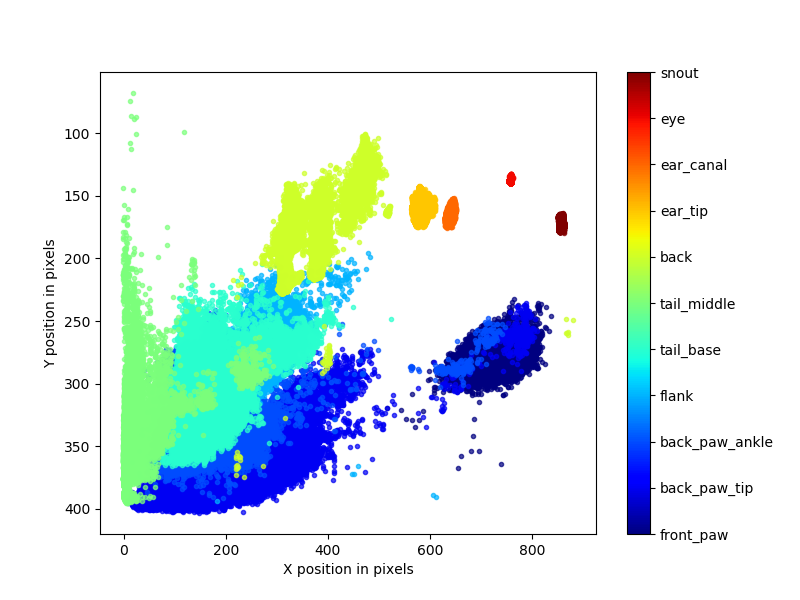

<IPython.core.display.Javascript object>


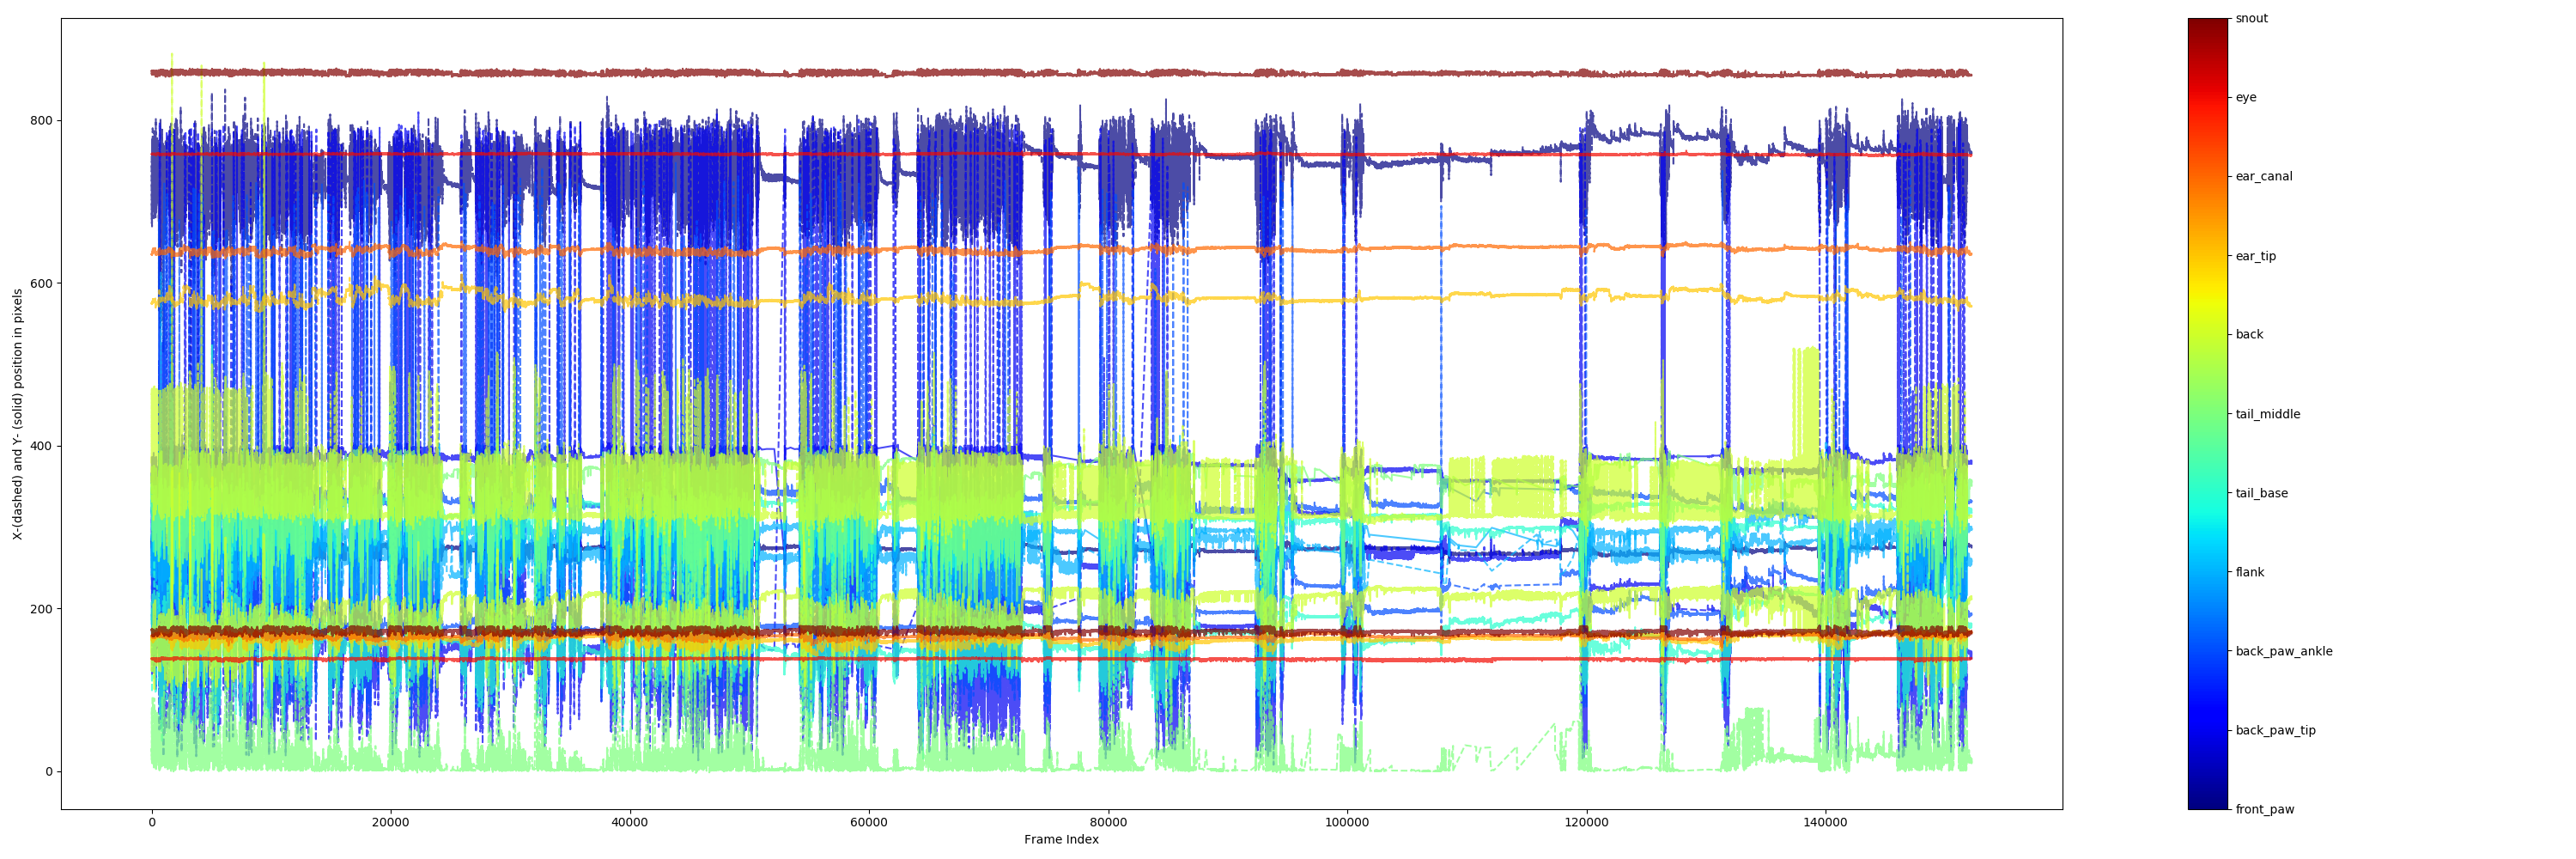

In [35]:
plot_raw_data(data, pcutoff=.6, cmap_name='jet')

<IPython.core.display.Javascript object>


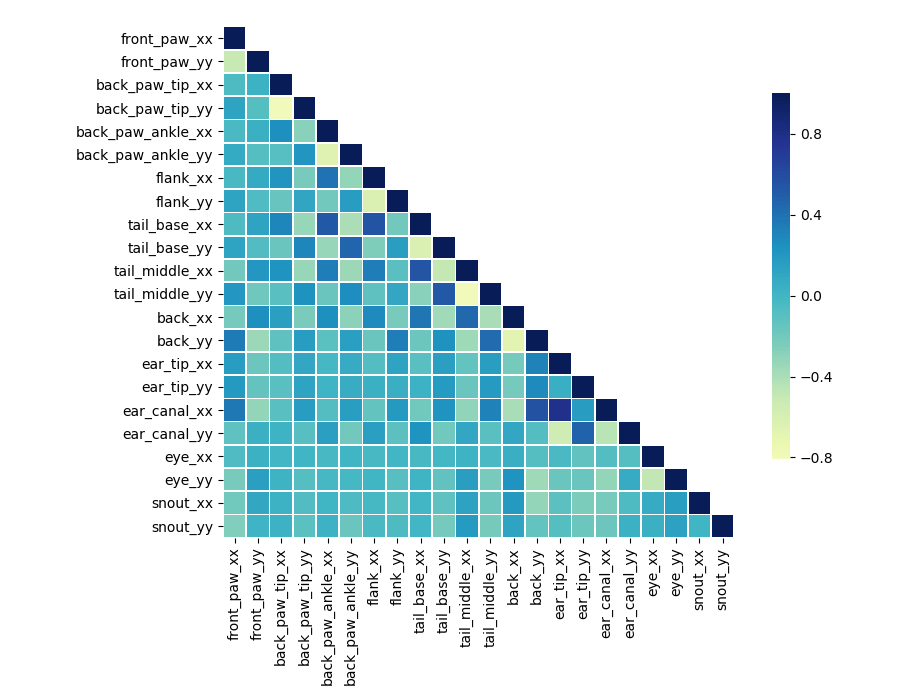

In [29]:
# Creating correlation matrix
corr_pars = pd.DataFrame.corr(data_xy)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_pars, dtype=np.bool), k=1)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = 'YlGnBu'

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_pars, mask=mask, cmap=cmap, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})

# Fixing the bug that causes incorrect plotting
ax.set_ylim(len(corr_pars), -.5)
plt.tight_layout()


### <font color='grey'>Branch </font>PCA_and_KMeans

Applying mixture of PCA and KMeans to see something.
* Standardize features by removing the mean and scaling to unit variance:
$$z = {x- \mu \over \sigma}$$

In [28]:
# Select only certain columns based on their correlation coeff. > 0.3
x = data_xy.loc[:, ['tail_base_xx', 'back_paw_ankle_xx', 'flank_xx', 'tail_middle_xx', 'back_xx']].values

# Allows for selecting entire set of features
# x = data_xy.loc[:, :]

# Standardizing our data according to above. This way we get our rescaled data with 0 mean and standard deviation of 1;
x = StandardScaler().fit_transform(x)

<IPython.core.display.Javascript object>


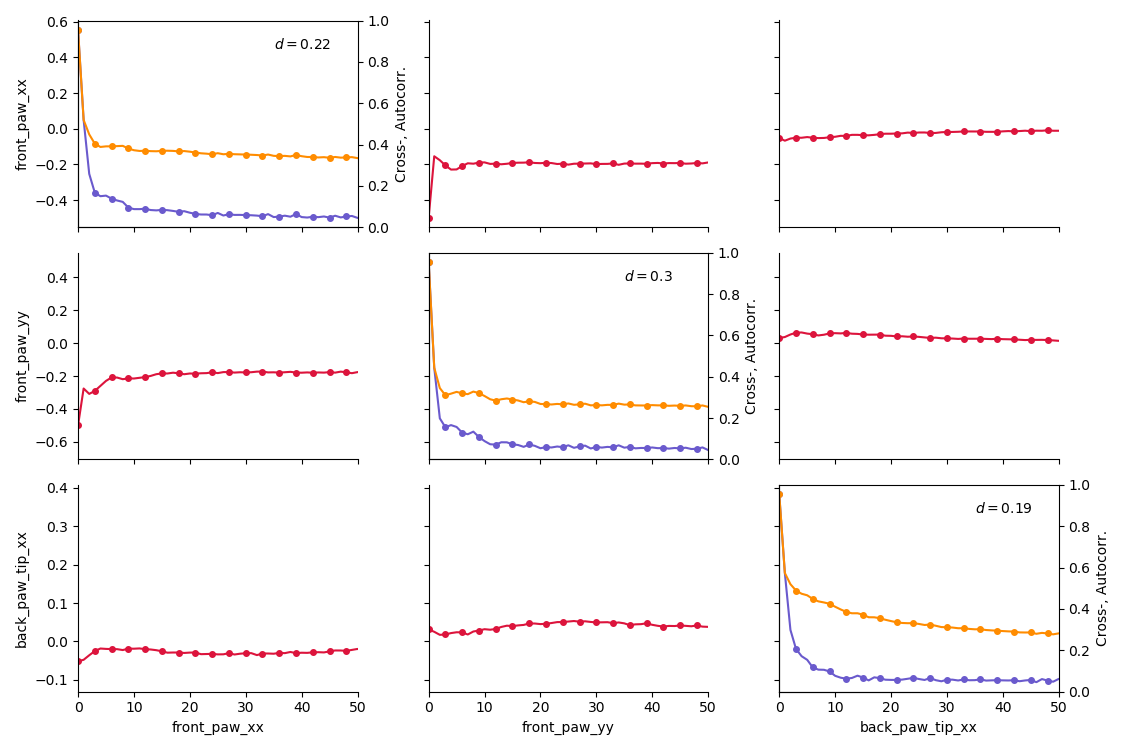

In [39]:
# Let's plot Auto- and Crosscorrelations across features to determine the window size for data_expander() //
# and get some sense of data

g = sns.PairGrid(data_xy.iloc[:, :3], diag_sharey=False, aspect=1.5)
a = g.map_diag(plot_PACF, alpha=None, use_vlines=False, markevery=3,
               markersize=4, linestyle=None, color='slateblue')
b = g.map_diag(plot_ACF, alpha=None, use_vlines=False, markevery=3,
               markersize=4, linestyle=None, color='darkorange')
c = g.map_diag(DW_statistic_display)

g = g.map_offdiag(plot_CCF, marker='o', markevery=3, markersize=4, color='crimson')

for i in range(3):
    g.axes[i,i].set_xlim((0,50))
    ax_x = g.axes[i,i].twinx()
    ax_x.set_ylabel('Cross-, Autocorr.')

plt.tight_layout()
plt.show()
# plt.savefig('summary_plot_trunc-1')

In [40]:
# Expands data using data_expander(). Window is determined by the above algorithm
x_expanded = data_expander(x, 10)

In [ ]:
# NOTE: I'm not sure whether it's valid to use such a rejector. But I left it here just in case
outlier_rejector(x_expanded)

In [41]:
# Creating entity with Incremental PCA algorithm
data_normed_ipca = IncrementalPCA(n_components=4)

# Fitting model with Incremental PCA algorithm
principalComponents_data_ipca = data_normed_ipca.fit_transform(x_expanded)

# Creating DataFrame with Principal Components
data_components = pd.DataFrame(principalComponents_data_ipca,
                               columns=[f"PC{i + 1}" for i in range(data_normed_ipca.n_components_)])

data_components.head()

,PC1,PC2,PC3,PC4
0,2.673944,0.505686,-2.043557,-0.915069
1,2.454714,0.332001,-1.911305,-0.790539
2,2.560872,0.749579,-2.091363,-0.806415
3,2.743314,1.320008,-2.415118,-0.892602
4,2.906638,1.875372,-2.727833,-1.005674


<IPython.core.display.Javascript object>


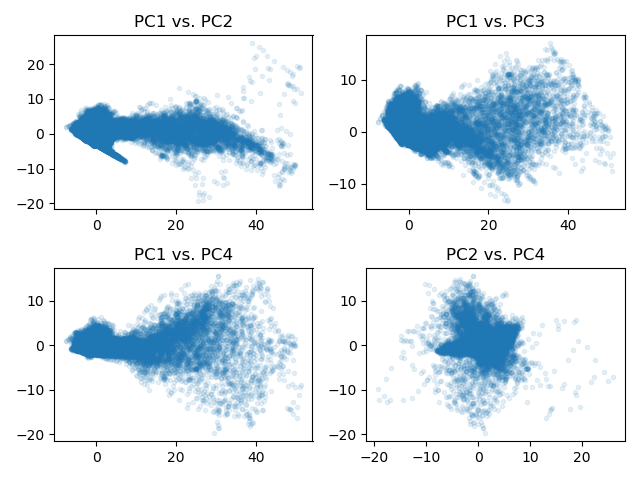

<IPython.core.display.Javascript object>


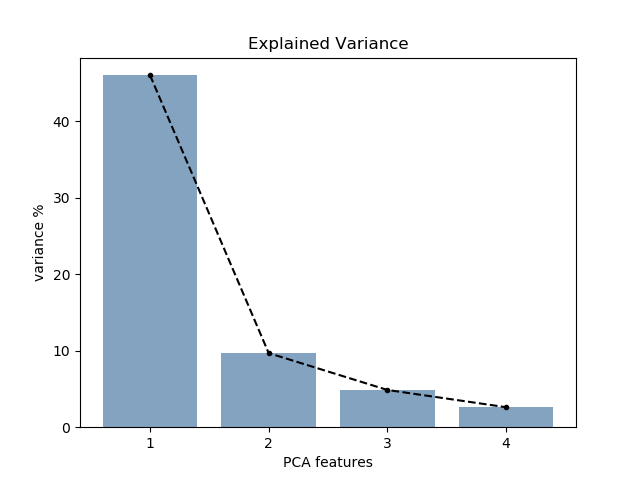

In [42]:
# Plotting summary plots
fig_PCA_summary, axs_PCA_summary = plt.subplots(2, 2)

axs_PCA_summary[0,0].plot(principalComponents_data_ipca[:, 0],principalComponents_data_ipca[:, 1],
                          '.', alpha=.1)

axs_PCA_summary[0,0].set_title('PC1 vs. PC2')
axs_PCA_summary[0,1].plot(principalComponents_data_ipca[:, 0], principalComponents_data_ipca[:, 2],
                          '.', alpha=.1)

axs_PCA_summary[0,1].set_title('PC1 vs. PC3')
axs_PCA_summary[1,0].plot(principalComponents_data_ipca[:, 0], principalComponents_data_ipca[:, 3],
                          '.', alpha=.1)

axs_PCA_summary[1,0].set_title('PC1 vs. PC4')
axs_PCA_summary[1,1].plot(principalComponents_data_ipca[:, 1], principalComponents_data_ipca[:, 3],
                          '.', alpha=.1)

axs_PCA_summary[1,1].set_title('PC2 vs. PC4')
plt.tight_layout()

fig_explained_variance = plt.figure()

features = range(1, data_normed_ipca.n_components_ + 1)
plt.bar(features, data_normed_ipca.explained_variance_ratio_ * 100, color=(0.2, 0.4, 0.6, 0.6))
plt.plot(features, data_normed_ipca.explained_variance_ratio_ * 100, '.--', color='black')
plt.title('Explained Variance')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

plt.show()

Once we got the principal components, let's now try to **clusterize** it to see if there's anything out there.
<br>We're going to be using **Elbow method** for determining the optimal amount of clusters for our dataset. https://en.wikipedia.org/wiki/Elbow_method_(clustering)

<IPython.core.display.Javascript object>


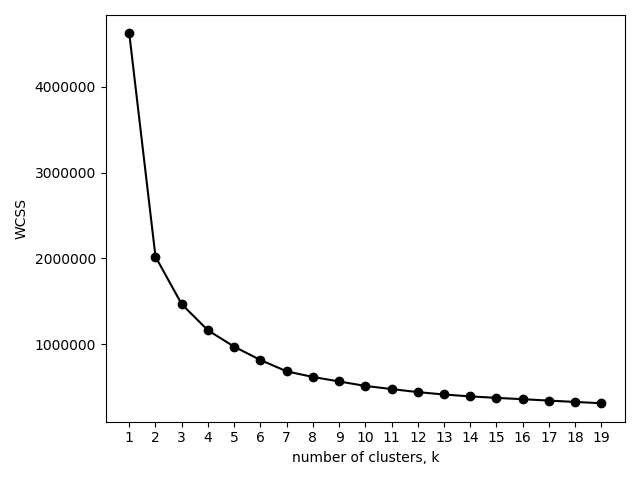

In [43]:
ks = range(1, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(principalComponents_data_ipca[:, :3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.figure()
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('WCSS')
plt.xticks(ks)
plt.tight_layout()
plt.show()

Having selected the number of clusters, let's now fit the model and plot the data.

In [50]:
# Creating KMeans entity with certain number of clusters
model = KMeans(n_clusters=6)

# Fitting model with our principal components
model.fit(principalComponents_data_ipca[:, :3])

# Assigning labels to each sample (frame) in our dataset
data_components['target'] = model.labels_

# Let's take a look at it
data_components.head(10)

,PC1,PC2,PC3,PC4,target
0,2.673944,0.505686,-2.043557,-0.915069,3
1,2.454714,0.332001,-1.911305,-0.790539,3
2,2.560872,0.749579,-2.091363,-0.806415,3
3,2.743314,1.320008,-2.415118,-0.892602,3
4,2.906638,1.875372,-2.727833,-1.005674,3
5,3.258846,2.415298,-3.018618,-1.161278,3
6,3.608419,2.950728,-3.302242,-1.284844,3
7,3.516435,2.804734,-3.180158,-1.247218,3
8,3.455277,2.877338,-3.161147,-1.128997,3
9,2.715303,3.331595,-2.828135,-0.798540,3


<IPython.core.display.Javascript object>


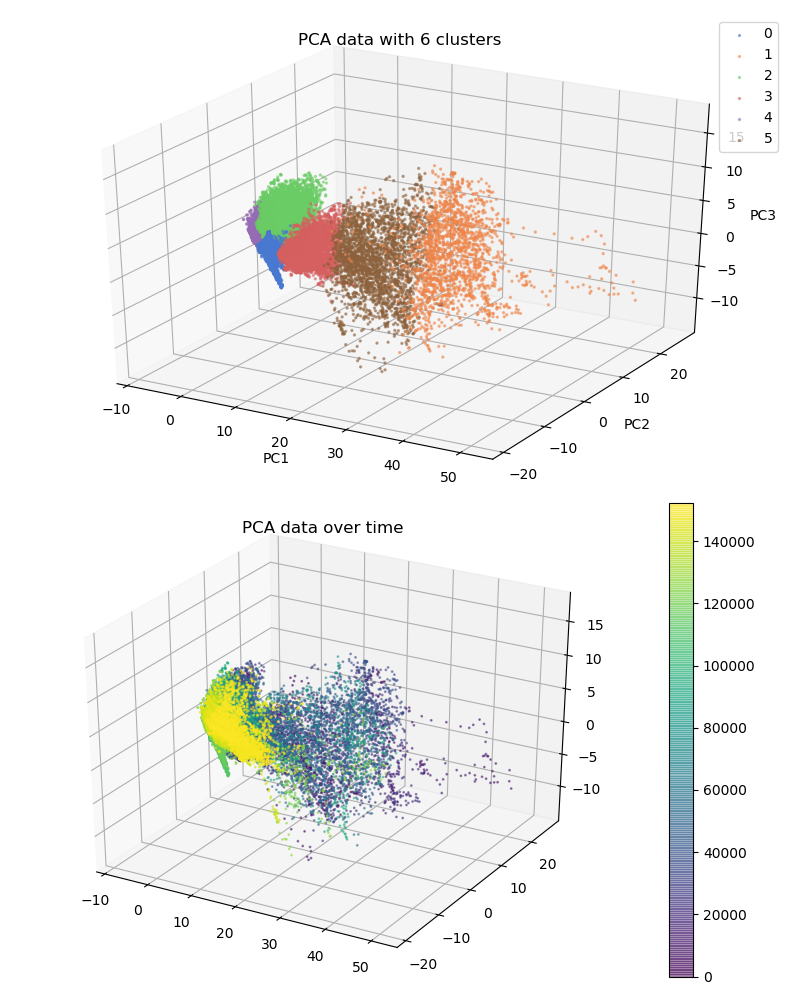

In [51]:
# Plotting our data
fig, ax, ax1 = plot_scatter3D(principalComponents_data_ipca)

# plt.savefig('saved_figs/PCA_comparison-111.png')

# This is to be able to rotate both figures simultaneously
canvas = fig.canvas.mpl_connect('motion_notify_event', on_move)